# Gale Shapley Matching with Bandits

To decide a matching between $\mathcal{B}$ and $\mathcal{L}$, we introduce the binary decision variable $\mathbf{x}$ := $(x_{bl})_{(b, l)\in \mathcal{B} \times \mathcal{L}}$ such that $x_{bl}$ = 1 if the loan from lender $l$ is assigned and accepted by borrower $b$ and 0 otherwise. It is supposed that when the borrower $b$ and the lender $l$ are matched, the borrower and the lender gain utilities of $u_b(h)$ and $u_l(h)$ respectively. To simplify  our settings, we assume that all utilities $u_b(h)$ and $u_l(h)$ are non-negative, and that for a lender $l$, $u_b(l)$ $\neq$ $u_{b'}(l)$, for $b \neq b'$ and similarly, for a borrower $b$, $u_l(b)$ $\neq$ $u_{l'}(b)$, for $l \neq l'$. The borrower-lender pair $(b, l)$ yields the utility of $u_{bl}:= u_b + u_l $ and the total utility of a matching $\mathbf{x} \in {0, 1}^{|\mathcal{B}| \times |\mathcal{L}|}$ is given by

\begin{equation*}
    \sum_{b \in \mathcal{B}} \sum_{l \in \mathcal{L}} u_{bl} x_{bl}
\end{equation*}
In our work, we consider a \textcolor{red}{many-many matching} where each borrower is matched to many lenders and each lender is also matched to multiple borrowers. For a matching $\mathbf{x}$, let $m_x(b)\in \mathcal{L}$ be the lender to which the borrower $b$ is assigned, and $M_x(l) \subseteq \mathcal{B}$ be the set of borrowers that are assigned to lender $l$, that is,
\begin{align*}
    m_x(b) = l \Longleftrightarrow x_{bl} = 1 \\
    M_x(l) := \{l \in \mathcal{L} \ | \ x_{bl} = 1\}
\end{align*}
\\

\noindent \textbf{Definition 1} Let $\mathbf{x} \in \{0, 1\}^{|\mathcal{B}| \times |\mathcal{L}|}$ be a matching. A pair $(b, l) \in \mathcal{B} \times \mathcal{L}$ is a blocking pair for $\mathbf{x}$ if the following conditions are satisfied:

\begin{enumerate}
    \item $x_{bl}=0$
    \item $x(b)$ is null or $u_b(l)$ $>$ $u_{b}(m_x(b))$
    \item $|M_x(b)|$ $< q_b$ or $\exists$ $l' \in M_x(b)$ and such that $u_b(l) > u_b(l')$.
\end{enumerate} 
\vspace*{.1in}

Since the individual rationality condition is fulfilled from Assumption 1 for all $(b, l) \in \mathcal{B} \times \mathcal{L}$, a stable matching is defined based on the absence of blocking pairs as follows: a matching $\mathbf{x}$ is stable if it does not have any blocking pairs. \\

\noindent \textbf{Definition 2.} A matching $\mathbf{x}$ is stable if it does not have blocking pairs. The stable matching problem can be characterized by the following linear inequalities as mentioned in \cite{baiou2000stable} and is formalized using the following inequality:

\begin{equation} \label{eq:eq1}
    q_b x_{bl} + q_b\sum_{l' \succ_b l }x_{bl'} + \sum_{b' \succ_{l} b} x_{b'l} \geq q_l
\end{equation}
The proof of the statement can be found in the same paper \cite{baiou2000stable}. We use this notation to arrive at a linear program that maximizes the utility of the matching while minimizing the number of blocking pairs. Defining a binary decision variable $\mathbf{w}$ := $(w_{b, l})$ $\in \{0, 1\}^{|\mathcal{B}| \times |\mathcal{L}|}$, we use the following constraint: 

\begin{equation}
        q_b x_{bl} + q_b\sum_{l' \succ_b l }x_{bl'} + \sum_{b' \succ_{l} b} x_{b'l} \geq q_l (1- w_{bl})
\end{equation}

In [155]:
import pandas as pd
import numpy as np
from gurobipy import *
import random
from collections import defaultdict 
import math

In [198]:
def model_gs_matching(n_b, n_l, u_b, u_l, c, q, obj_util, lambda_1, lambda_2, LogToConsole=True, TimeLimit=60):
    model = Model()
    model.params.LogToConsole = LogToConsole
    model.params.TimeLimit = TimeLimit # seconds
    x = {}
    w = {}
    for b_idx in range(1, n_b+1):
        x[b_idx] = {}
        w[b_idx] = {}
        for l_idx in range(1, n_l+1): 
            x_name = "x_{}_{}".format(b_idx, l_idx)
            x[b_idx][l_idx] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.BINARY, name=x_name)
            w_name = "w_{}_{}".format(b_idx, l_idx)
            w[b_idx][l_idx] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.BINARY, name=w_name)

    for l_idx in range(1, n_l+1):
        model.addConstr(quicksum(x[b_idx][l_idx] for b_idx in range(1, n_b+1)) <= 1)
    
    for b_idx in range(1, n_b+1):
        model.addConstr(quicksum((q[l_idx]*x[b_idx][l_idx]) for l_idx in range(1, n_l+1)) >= c[b_idx])
    
    for b_ix in range(1, n_b+1):
        for l_idx in range(1, n_l+1):
            constr_obj_1 = c[b_idx]*x[b_idx][l_idx]
            constr_obj_2 = 0
            constr_obj_3 = 0
            
            for b_idx_2 in range(1, n_b+1):
                if b_idx != b_idx_2:
#                     print(b_idx, b_idx_2)
                    if u_l[l_idx][b_idx] < u_l[l_idx][b_idx_2]:
                        constr_obj_2 += (x[b_idx][l_idx])
            constr_obj_2 *= c[b_idx] 

            for l_idx_2 in range(1, n_l+1):
                if l_idx != l_idx_2:
                    if u_b[b_idx][l_idx] < u_b[b_idx][l_idx_2]:
                        constr_obj_3 += (q[l_idx] * x[b_idx][l_idx])
                        
            model.addConstr((constr_obj_1 + constr_obj_2 + constr_obj_3) >= (c[b_idx]* (1-w[b_idx][l_idx])))
    
    model.setObjective(lambda_1*quicksum(obj_util[b_idx][l_idx]*x[b_idx][l_idx] for l_idx in range(1, n_l+1) for b_idx in range(1, n_b+1)) - \
                       lambda_2*quicksum(w[b_idx][l_idx] for l_idx in range(1, n_l+1) for b_idx in range(1, n_b+1)) , GRB.MAXIMIZE)
    model.optimize()
    if model.status != 2:
        print("Optimal Solution not found !!!")
        return -1, -1
    
    borrower_matches = {}
    lender_matches = {}
    for b_idx in range(1, n_b+1):
        borrower_matches[b_idx] = []
#         print("Borrower {} matched to lenders: ".format(b_idx))
        for l_idx in range(1, n_l+1):
            if x[b_idx][l_idx].X == 1:
#                 print(l_idx)
                borrower_matches[b_idx].append(l_idx)
                if l_idx not in lender_matches:
                    lender_matches[l_idx] = -1
                lender_matches[l_idx] = b_idx
    
    return borrower_matches, lender_matches, model.objVal

In [199]:
def lender_utility(l, b, sim_values, amount_lenders, borrower_rates):
    return sim_values[b][l] #+ borrower_rates[b]*amount_lenders[l]

# Risk preference not considered for now
def borrower_utility(l, b, sim_values, risk_preference):
    return (sim_values[b][l] + risk_preference[b][l])/2.0 # 2.0 is for normalization

In [225]:

VARIANCE = 0.3
NUM_SIMS_PER_STEP=50
def rewards(mean, variance):
    return np.random.normal(mean, variance, 1)[0]

def average_reward(base_reward, rewards_list):
    return base_reward + (rewards(1, VARIANCE) + np.sum(rewards_list))/(len(rewards_list)+1) 

def reward_ucb(base_reward, rewards_list, time):
    avg_reward = average_reward(base_reward, rewards_list)
    
    if len(rewards_list) > 1:
        return avg_reward + np.sqrt(2*np.log(time)/(len(rewards_list)-1))
    else:
        return avg_reward
    

def gs_bandit_method_baseline(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, preference_borrowers, preference_lenders):
    u = defaultdict(lambda: defaultdict(float))
    obj = defaultdict(lambda: defaultdict(float))
    for l_idx in range(1, n_l+1):
        for b_idx in range(1, n_b+1):
            # we optimize for lender_borrower returns
            u[l_idx][b_idx] = u_b[b_idx][l_idx] + u_l[l_idx][b_idx] # lender utility + borrower utility
            obj[b_idx][l_idx] = u[l_idx][b_idx] # objective fn utility same as lender-borrower utility

    borrower_matches_optimal, lender_matches_optimal, objVal = model_gs_matching(n_b, n_l, u_b, u, c, q, obj, lambda_1, lambda_2, LogToConsole=False)
  
    return lender_matches_optimal, objVal
            
    
    
def gs_bandit_method_basic(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, preference_borrowers, preference_lenders):
    T = 10 # horizon, n
    
    curr_util_l = defaultdict(lambda: defaultdict(list))
    rewards_list_l = defaultdict(lambda: defaultdict(list))
    util_send_l = defaultdict(lambda: defaultdict(float))
    
    # For each lender l, initialize the current utility for a borrower b as u_l(b) + N(1, 0.25)
    # and then initilize the util_send list for matching with the current utility
    for l_idx in range(1, n_l+1):
        for b_idx in range(1, n_b+1):
            curr_util_l[l_idx][b_idx] = average_reward(u_l[l_idx][b_idx], rewards_list_l[l_idx][b_idx])
            util_send_l[l_idx][b_idx] = curr_util_l[l_idx][b_idx]
    
    # Baseline GS
    lender_matches_optimal = []
    while ( len(lender_matches_optimal) < n_l):
        lender_matches_optimal, objVal_optimal = gs_bandit_method_baseline(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, preference_borrowers, preference_lenders)
    
    
    regret_lender_t = defaultdict(lambda: defaultdict(list))
    
    for s_idx in range(NUM_SIMS_PER_STEP):
        print("Simulation no.: " + str(s_idx))
        for t in range(1, T+1):
            print("Matching time step " + str(t))
    #         u = {}
    #         for b_idx in range(1, n_b+1):
    #             u[b_idx] = {}
    #             for l_idx in range(1, n_l+1):
    #                 u[b_idx][l_idx] = u_l[l_idx][b_idx] #lender optimal
            borrower_matches, lender_matches, objVal = model_gs_matching(n_b, n_l, u_b, util_send_l, c, q, util_send_l, lambda_1, lambda_2, LogToConsole=False)
#             if borrower_matches == -1 or lender_matches == -1:
#                 print("Non-optimal lending")
#                 for l_idx in range(1, n_l+1):
#                     regret_lender_t[l_idx].append(-1)
#                 continue

            for l_idx in range(1, n_l+1):
                if l_idx in lender_matches:
                    b_match = lender_matches[l_idx] # matched borrower
                    rewards_list_l[l_idx][b_match].append(rewards(u_b[b_match][l_idx], VARIANCE)) # update the reward list for l-b pair
                    # For each lender l, the current utility for a borrower b becomes u_l(b) + [N(1, 0.25) + \sum (rewards_list)]/(1 + len(rewards_list))
                    # util_send becomes curr_util[l][b] + sqrt(2*log t/T_{b,l}(t-1))
                    curr_util_l[l_idx][b_match] = average_reward(u_l[l_idx][b_match], rewards_list_l[l_idx][b_match])
                    util_send_l[l_idx][b_match] = reward_ucb(u_l[l_idx][b_match], rewards_list_l[l_idx][b_match], t)

                    # print(lender_matches_optimal[l_idx], b_match)
                    r = u_l[l_idx][lender_matches_optimal[l_idx]] + u_b[lender_matches_optimal[l_idx]][l_idx] - u_l[l_idx][b_match]
                else:
#                     if len(regret_lender_t[l_idx][s_idx]) > 0:
#                         r = regret_lender_t[l_idx][s_idx][-1] # same as before
#                     else:
                    r = u_l[l_idx][lender_matches_optimal[l_idx]] + u_b[lender_matches_optimal[l_idx]][l_idx]
              
                regret_lender_t[l_idx][t].append(r)
            
                print("Lender {} with regret {}".format(l_idx, r))
    
    return regret_lender_t
    

In [226]:
def gs_bandit_method(n_b, n_l, preference_borrowers, preference_lenders):
    T = 100 # horizon, n
    
    for t in range(T):
        l_unmatched = n_l
        
        while len(l_unmatched) > 0:
            borrower_matches, lender_matches = model_gs_matching(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, LogToConsole=False)

            if borrower_matches == -1:
                print("Matching has reached an unstable configuration. Aborting!!!")
                break

            for l_idx in lender_matches:
                b_matched_l = lender_matches[l_idx][0] # every lender has 1 borrower
                b_most_preferred_l = preference_borrowers[b_idx][0]

#                 if b_matched_l == b_most_preferred_l:
                    

            
        
    return ""

In [227]:
def simulate_lending():
    u_b = {}
    u_l = {}
    
    n_b, n_l = 20, 60

    preference_borrowers = []
    preference_lenders = []
    
    sim_values = {}
    for b_idx in range(1, n_b+1):
        sim_values[b_idx] = {}
        for l_idx in range(1, n_l+1):
            sim_values[b_idx][l_idx]  = random.uniform(0, 1)
    
    borrower_rates = {}
    for b_idx in range(1, n_b+1):
        borrower_rates[b_idx]  = random.uniform(0, 1)

    # This part is not used for now - risk_preference
    risk_preference = {}
    categories = list(range(1, 6))
    lender_risk_categories = {}
    for l_idx in range(1, l_idx+1):
        lender_risk_categories[l_idx] = {}
        for c_idx in categories:
            lender_risk_categories[l_idx][c_idx] = random.uniform(0, 1)
    borrower_categories = {}
    for b_idx in range(1, n_b+1):
        borrower_categories[b_idx] = random.sample(categories, 1)[0] # consider every borrower has 1 category for now
        risk_preference[b_idx] = {}
        for l_idx in range(1, n_l+1):
            risk_preference[b_idx][l_idx] = lender_risk_categories[l_idx][borrower_categories[b_idx]]
    
    # c - borrower amount, q - lender amount
    c = {}
    q = {}

    while True:
        sum_c = 0
        sum_q = 0
        for b_idx in range(1, n_b+1):
            c[b_idx] = random.sample(range(5, 40), 1)[0]
            sum_c += c[b_idx]

        for l_idx in range(1, n_l+1):
            q[l_idx] = random.sample(range(1, 10), 1)[0]
            sum_q += q[l_idx]

        if sum_q > sum_c:
            break

    # utilities
    for b_idx in range(1, n_b+1):
        u_b[b_idx] = {}
        for l_idx in range(1, n_l+1):
            u_b[b_idx][l_idx] = borrower_utility(l_idx, b_idx, sim_values, risk_preference)
        preference_borrowers = sorted(range(1, len(u_b[b_idx])+1), key=lambda k: u_b[b_idx][k])

    for l_idx in range(1, n_l+1):
        u_l[l_idx] = {}
        for b_idx in range(1, n_b+1):
            u_l[l_idx][b_idx] = lender_utility(l_idx, b_idx, sim_values, q, borrower_rates)
        preference_lenders = sorted(range(1, len(u_l[l_idx])+1), key=lambda k: u_l[l_idx][k])
    
    lambda_1 = 0.5
    lambda_2 = 1-lambda_1

    print("Configuration:")
    print("Borrower preferences: ", u_b)
    print("Borrower requests: ", c)
    print("Lender prefernces: ", u_l)
    print("Lender budgets: ", q)
    
    return gs_bandit_method_basic(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, preference_borrowers, preference_lenders)
#     model_gs_matching(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, LogToConsole=False)

In [228]:
import matplotlib.pyplot as plt

def plot_lines(regret):
    for l_idx in regret:
        time_points = []
        time_points_ub = []
        time_points_lb = []
        max_ub = -1
        min_lb = 10
        
        for t_idx in regret[l_idx]:
            time_points.append(np.mean(regret[l_idx][t_idx]))
            time_points_ub.append(np.mean(regret[l_idx][t_idx]) + np.std(regret[l_idx][t_idx]))
            time_points_lb.append(np.mean(regret[l_idx][t_idx]) - np.std(regret[l_idx][t_idx]))
            
            if (np.mean(regret[l_idx][t_idx]) + np.std(regret[l_idx][t_idx])) > max_ub:
                max_ub = np.mean(regret[l_idx][t_idx]) + np.std(regret[l_idx][t_idx])
                                                    
            if (np.mean(regret[l_idx][t_idx]) - np.std(regret[l_idx][t_idx])) < min_lb:
                min_lb = np.mean(regret[l_idx][t_idx]) - np.std(regret[l_idx][t_idx])
                                                                
        x = range(len(time_points))
        plt.plot(x, time_points, 'k-')
        plt.fill_between(x, time_points_lb, time_points_ub)
        plt.ylim([max_ub+.2*max_ub, min_lb - .2*min_lb])
        plt.show()
    

In [229]:

regret_lender = simulate_lending()



Configuration:
Borrower preferences:  {1: {1: 0.7348054530314665, 2: 0.339452020436862, 3: 0.6134223678766094, 4: 0.4118433711524476, 5: 0.7300848865081953, 6: 0.15483687603040025, 7: 0.4950313556027723, 8: 0.40477181413258134, 9: 0.533681615316634, 10: 0.3820361053949993, 11: 0.9561418784578384, 12: 0.6296134463720459, 13: 0.3864385968858632, 14: 0.27639093521106556, 15: 0.41121877274290886, 16: 0.6158966377410113, 17: 0.2694799016290833, 18: 0.5231884384661104, 19: 0.5245000040086059, 20: 0.4551619794300322, 21: 0.501608322193389, 22: 0.2927442855739557, 23: 0.12093087539625474, 24: 0.7467754252388099, 25: 0.48991599503513367, 26: 0.5017678479747515, 27: 0.1560864040626656, 28: 0.8844998782355112, 29: 0.7402876825260579, 30: 0.43621227654171524, 31: 0.5499512527582797, 32: 0.6892499716691113, 33: 0.4442571404633133, 34: 0.7478995890692726, 35: 0.7514422912568963, 36: 0.6167245506838017, 37: 0.600147619953427, 38: 0.4687152637821706, 39: 0.3568913664208488, 40: 0.4490631565278885, 41:

Simulation no.: 0
Matching time step 1
Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 1.624376711106514
Lender 4 with regret 0.6424513891406076
Lender 5 with regret 1.2408530663937012
Lender 6 with regret 0.7644558585487952
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 0.7453721743504683
Lender 9 with regret 0.9130161766287621
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 1.0692611359887563
Lender 16 with regret 1.064467660790759
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 1.1027323259062234
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.226741961805188
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.0813509711113825
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.72203427254

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8601708744256553
Lender 4 with regret 0.34590223353706684
Lender 5 with regret 1.2408530663937012
Lender 6 with regret 0.7644558585487952
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.113493097689847
Lender 9 with regret 0.9130161766287621
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 0.9060535145873246
Lender 15 with regret 0.9818704483703633
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8487479185567351
Lender 19 with regret 0.9100284945075416
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.4647794178894595
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.5771218770886828
Lender 24 with regret 1.134142162981798
Lender 25 with regret 0.80302

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8601708744256553
Lender 4 with regret 0.34590223353706684
Lender 5 with regret 1.2408530663937012
Lender 6 with regret 0.7644558585487952
Lender 7 with regret 1.5787613743516584
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 0.9130161766287621
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 0.9382972558535073
Lender 14 with regret 0.9060535145873246
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 1.1027323259062234
Lender 19 with regret 1.203932682179167
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.650210671485395
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.6836226360342874
Lender 24 with regret 0.7220342725456886
Lender 25 with regret 0.89635

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 1.033733327310777
Lender 5 with regret 1.2408530663937012
Lender 6 with regret 1.5666138589881293
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7164113641217902
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 0.7886068736051772
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 0.8497892

Lender 1 with regret 1.148900495669951
Lender 2 with regret 0.7158049499646176
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 1.033733327310777
Lender 5 with regret 1.609309773971342
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.5787613743516584
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.9293809329798307
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0606941290164094
Lender 25 with regret 1.140128493

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.48989723692028775
Lender 5 with regret 1.2408530663937012
Lender 6 with regret 1.0813757160266406
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 0.9708649387854748
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8487479185567351
Lender 19 with regret 0.9100284945075416
Lender 20 with regret 1.40803701775717
Lender 21 with regret 1.4647794178894595
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.6873578507603866
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.1401

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 1.033733327310777
Lender 5 with regret 1.609309773971342
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.5787613743516584
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 0.9100284945075416
Lender 20 with regret 1.40803701775717
Lender 21 with regret 1.4647794178894595
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 1.6214465850

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 0.80302387

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.609309773971342
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.5787613743516584
Lender 8 with regret 1.287418032037876
Lender 9 with regret 1.0382133649722287
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 1.6214465850

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.650210671485395
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.14012849

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 1.621446

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.621446

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 1.6214465

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 0.88868917

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.888689

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.888689

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.888689

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 0.803023879

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.6214465

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8540285543718464
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.650210671485395
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 1.621446

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.8570872866100934
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5599977704367884
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.5343005608665472
Lender 25 with regret 1.621446

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.88868917

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 1.2607883113495097
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.8570872866100934
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.6839796767509834
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.5343005608665472
Lender 25 with regret 1.14012

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.888689

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.8570872866100934
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.6839796767509834
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.5343005608665472
Lender 25 with regret 1.657149

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 0.80302387

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 1.14012849

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 1.621446585

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.621446

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.80302387

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.8570872866100934
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.6839796767509834
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.592798927560737
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.5343005608665472
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 1.2607883113495097
Lender 5 with regret 1.8540285543718464
Lender 6 with regret 1.6974841935309315
Lender 7 with regret 1.8570872866100934
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.6100006496229873
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.6839796767509834
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5599977704367884
Lender 22 with regret 1.592798927560737
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.5343005608665472
Lender 25 with regret 1.657149

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.650210671485395
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.6214465

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.650210671485395
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 1.621446585

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.621446

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.650210671485395
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.592798927560737
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 0.80302387

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.14012849

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.888689

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 1.6214465

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.650210671485395
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.650210671485395
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 0.88868917

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.803023

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.650210671485395
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.62144658

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.414008379176563
Lender 25 with regret 1.6214465

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.1299641908613829
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.888689

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.5840372890673237
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.14012849

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.7488880145843342
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.443947074994501
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.14012849

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.0034870574585506
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 0.8886891

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.8801382749098998
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 0.8030238

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.0935477970286092
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.1004613600318178
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.140128

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 1.5263326454607344
Lender 22 with regret 1.212518270452323
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 0.5647308295267142
Lender 25 with regret 1.1401284

Lender 1 with regret 1.148900495669951
Lender 2 with regret 1.0158807849426803
Lender 3 with regret 0.8703735615654881
Lender 4 with regret 0.6564813784949264
Lender 5 with regret 1.8013726285577625
Lender 6 with regret 1.6016814732761766
Lender 7 with regret 1.6976902567568075
Lender 8 with regret 1.1674803506664473
Lender 9 with regret 1.2814363171050611
Lender 10 with regret 1.545822222272164
Lender 11 with regret 1.1100941152486445
Lender 12 with regret 0.8906562057604546
Lender 13 with regret 1.5731714383939308
Lender 14 with regret 1.67736027054058
Lender 15 with regret 0.6110178018972127
Lender 16 with regret 1.1279115112443363
Lender 17 with regret 0.7729205687163535
Lender 18 with regret 0.8782497230901875
Lender 19 with regret 1.308376806235219
Lender 20 with regret 1.6195567649147735
Lender 21 with regret 0.7488952228151929
Lender 22 with regret 1.5431765631257688
Lender 23 with regret 1.4034453884105091
Lender 24 with regret 1.2795320540070114
Lender 25 with regret 1.621446

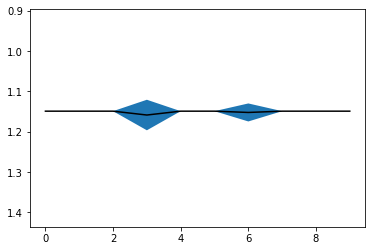

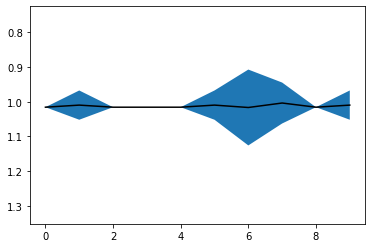

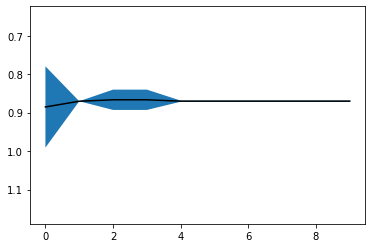

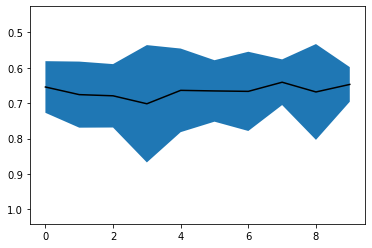

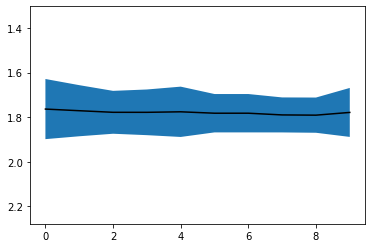

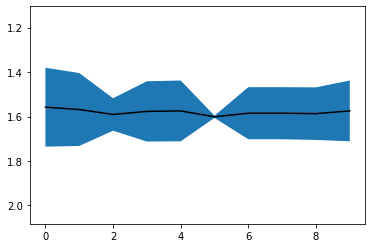

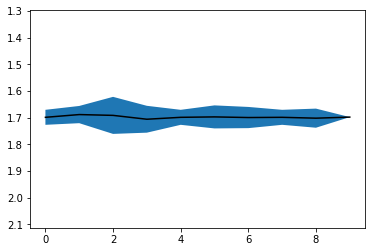

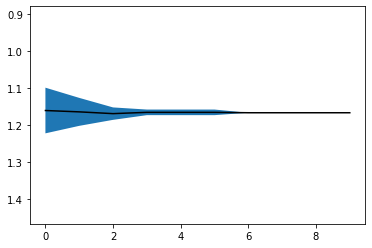

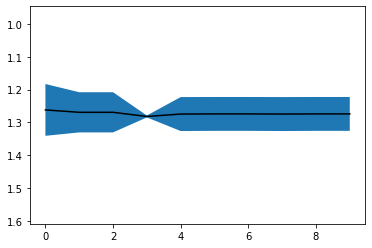

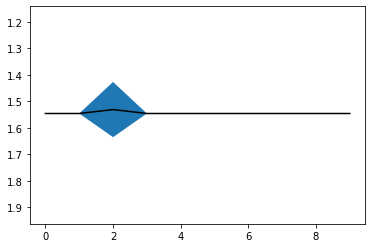

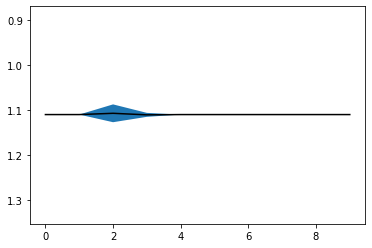

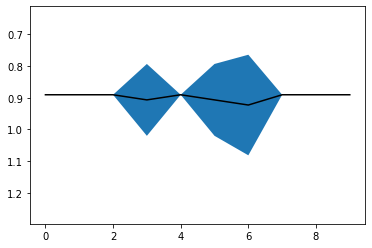

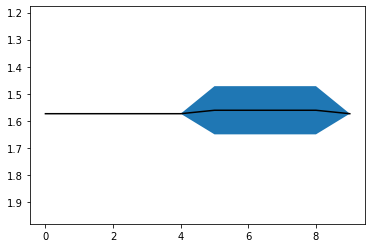

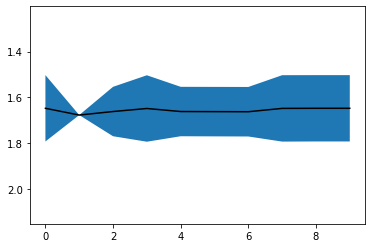

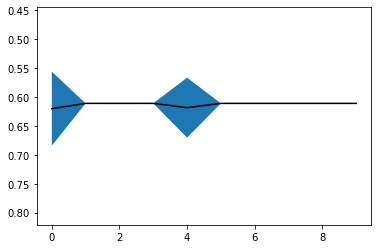

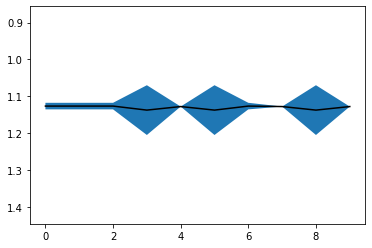

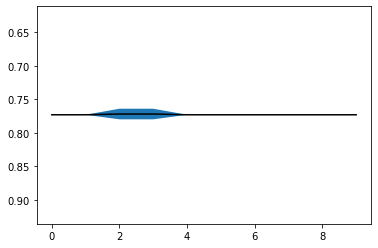

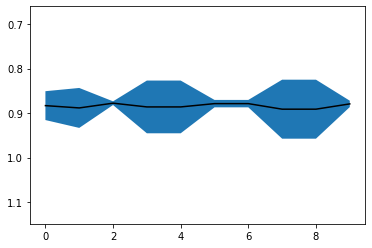

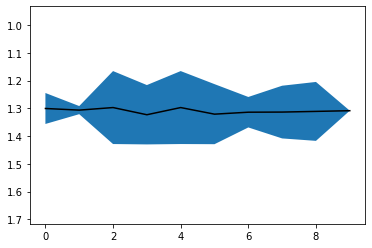

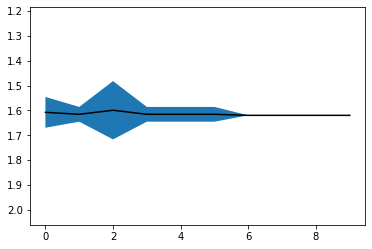

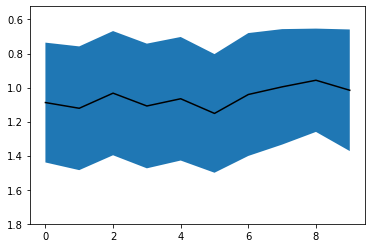

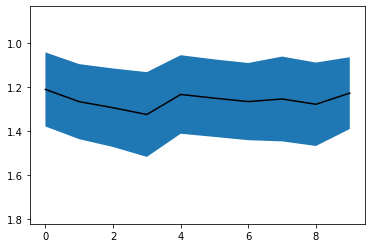

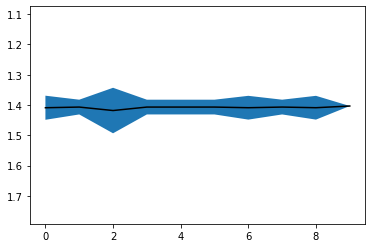

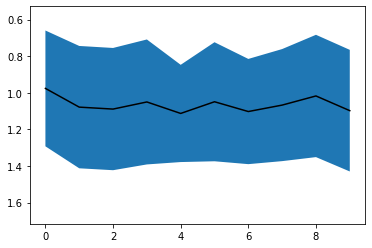

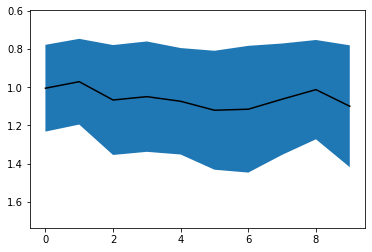

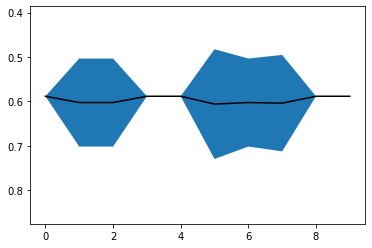

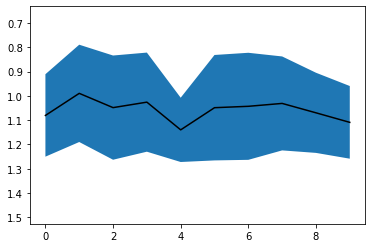

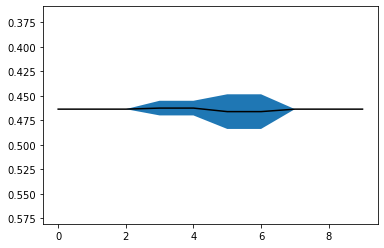

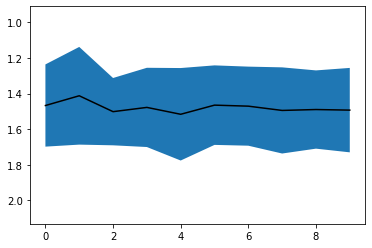

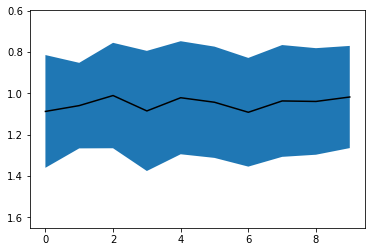

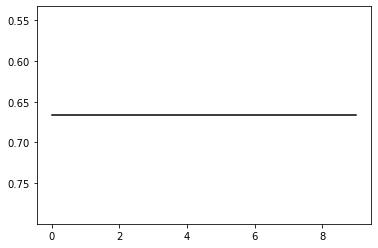

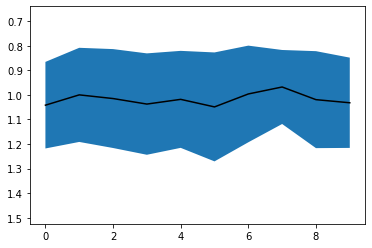

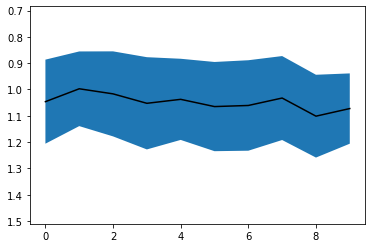

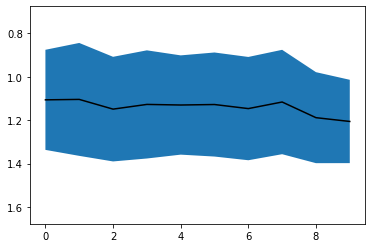

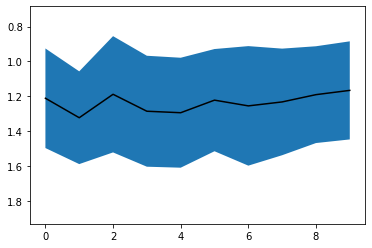

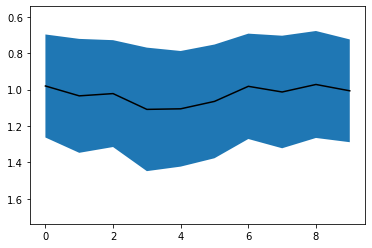

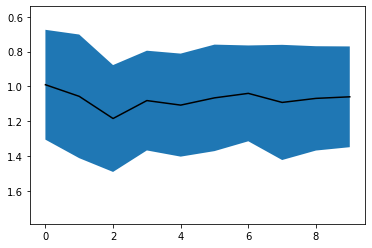

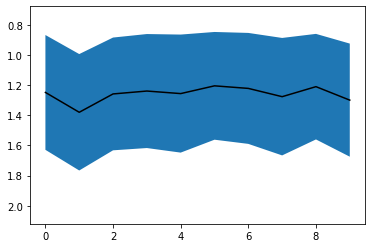

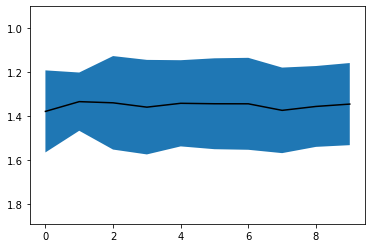

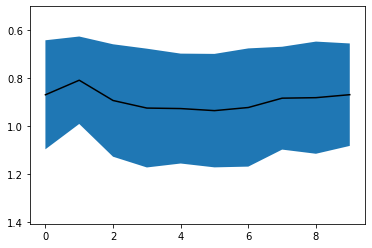

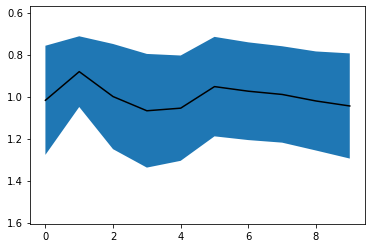

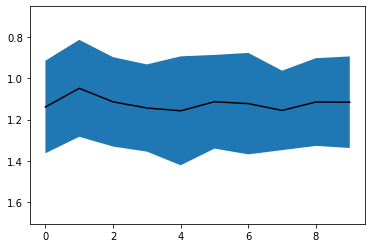

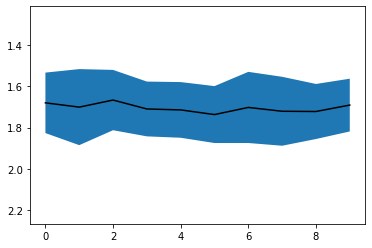

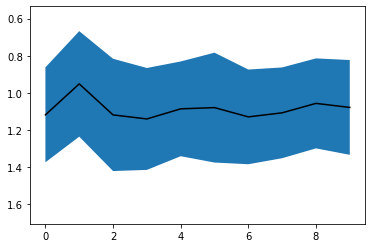

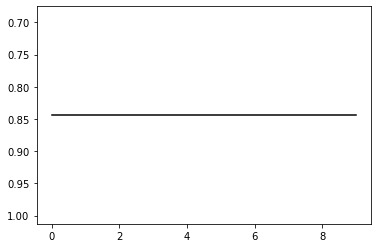

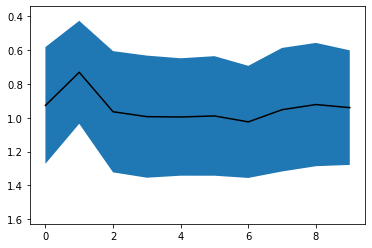

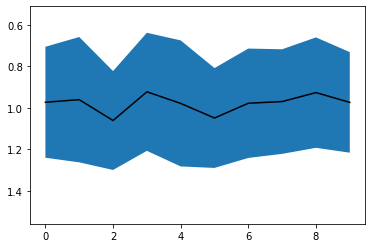

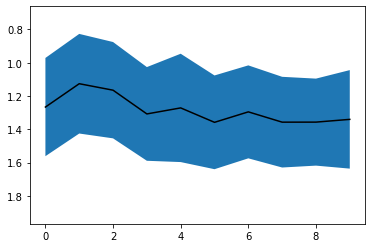

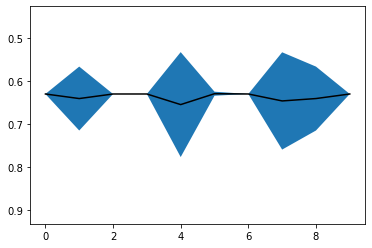

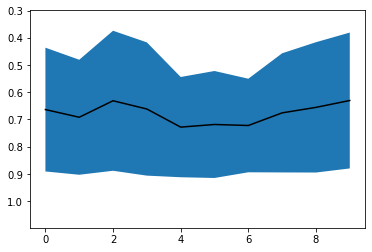

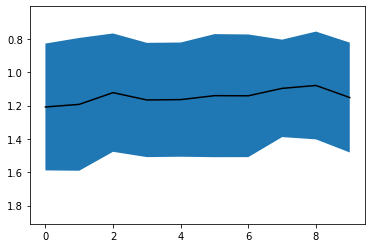

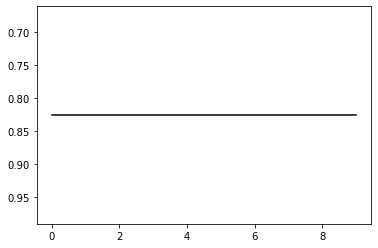

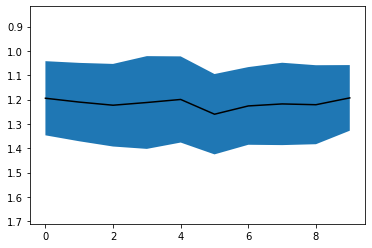

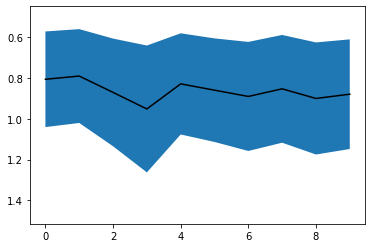

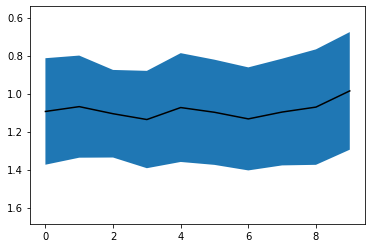

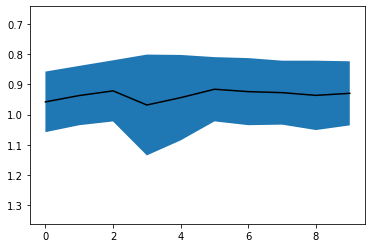

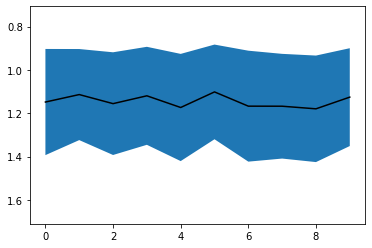

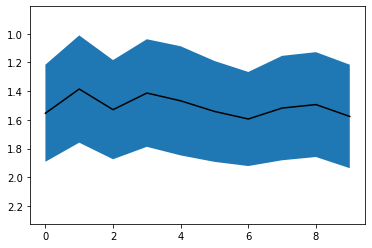

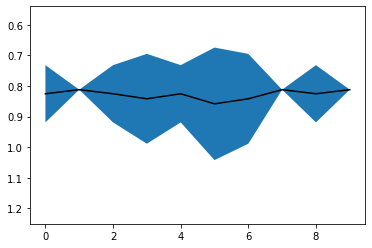

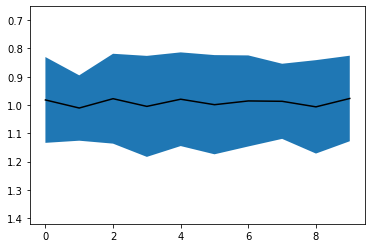

In [230]:
plot_lines(regret_lender)